# Introduction to Classification 
## 11/19/19
## Due 11/26/19 @ 11:59 PM

In [35]:
# Load the modules we'll need
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
plt.style.use('fivethirtyeight')

Today we'll explore the task of classification by seeing whether we can successfully predict a cell type given gene expression measurements. To do so, we'll use the single-cell RNA-seq data from last week. These data consist of B cells, T cells, and NK cells from the murine spleen. Let's start by loading and normalizing the data as we did previously.

In [36]:
# Load metadata for single cells
sc_meta = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab07/spleen_meta_sc.csv', sep = ',', header = 0).set_index('index').rename(columns ={'Unnamed: 0':'Sample Num'})
# Load single-cell expression data and normalize it
scRNA_data_pre = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab07/cell_data.csv', sep = ',', header = 0).set_index('Gene')
# These data were on log scale so let's go back to counts
sc_data = (2 ** scRNA_data_pre - 1)
sc_total_med = sc_data.sum().median()
sc_data_norm = sc_data / sc_data.sum() * sc_total_med

Classification is usually a supervised learning task. This means we have data for which we know the true class labels and want to build a model which can predict the label for new data based on what we've already observed. We hence want to get the labels and "features" for our data to prepare to build our model.

In [37]:
# Extract the cell type labels and gene expression values for all the cells. 
sc_labels = sc_meta.cell_ontology_class[:]   # The [:] prevents aliasing and generates a new copy
sc_features = sc_data_norm.T                 # We need to transpose our data to apply the classifier

One of the key components of model building is splitting our data into training and test sets. We use the training set to construct our model and then evaluate its performance on the test set. There are many ways to split into training and test sets, but our data are amenable to doing so in the most straightforward fashion. Fortunately, there's a handy function that will do everything for us.

In [38]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sc_features, sc_labels, test_size=0.3)

Having split our data, we are now ready to train our model. We're going to use a machine learning algorithm known as a random forest. Go ahead and run the following cell to build the classifier.

In [39]:
# Fit model
clf=RandomForestClassifier(n_estimators = 200)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We now want to compute the error rates on our traning and test sets. We can use the model to make predictions and then compare to what we know to be the truth.

In [40]:
# Compute train and test errors
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

[np.mean(y_train_pred == y_train), np.mean(y_test_pred == y_test)]

[1.0, 0.9938775510204082]

# How do these errors compare? Why do you think this is?
# Answer: The classifier performs a bit better on the training data because these are the data that were used to produce it (so it's seen them before). 

The confusion matrix is a useful way to visualize the performance of our algorithm. It shows how predictions compare to the truth for each class. Perfect classification would be a diagonal matrix.

In [41]:
# Produce confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[369,   0,   0],
       [  0,  12,   3],
       [  0,   0, 106]])

# Interpret your confusion matrix. What do you think it means? Does this make sense in light of the t-SNE plots we saw before?
# Answer: The matrix is nearly diagonal, so our classifier performs well. A few NK cells are classified as T cells, which makes sense because there aren't many NK cells and in the t-SNE plot they were very close to the larger group of T cells.

Let's generate plots of our data with the true and predicted labels to see how it does. We'll start by running t-SNE so that we can visualize our cell type clusters.

In [42]:
# Produce t-SNE embeddings
x = StandardScaler().fit_transform(np.log2(X_test+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

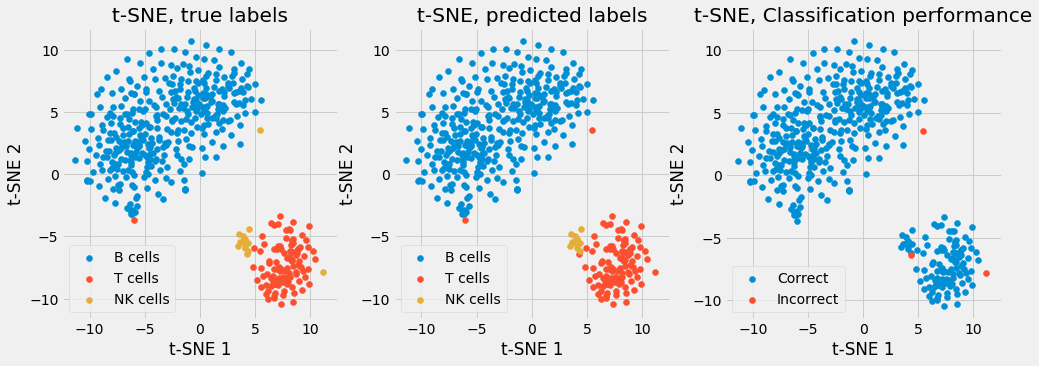

In [43]:
# Make a plot which colors points by the true labels, predicted labels, and whether the classifier was correct or not.
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(X_embedded[y_test == 'B cell',0], X_embedded[y_test == 'B cell',1])
plt.scatter(X_embedded[y_test == 'T cell',0], X_embedded[y_test == 'T cell',1])
plt.scatter(X_embedded[y_test == 'NK cell',0], X_embedded[y_test == 'NK cell',1])
plt.legend(['B cells','T cells', 'NK cells'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, true labels')

plt.subplot(132)
plt.scatter(X_embedded[y_test_pred == 'B cell',0], X_embedded[y_test_pred == 'B cell',1])
plt.scatter(X_embedded[y_test_pred == 'T cell',0], X_embedded[y_test_pred == 'T cell',1])
plt.scatter(X_embedded[y_test_pred == 'NK cell',0], X_embedded[y_test_pred == 'NK cell',1])
plt.legend(['B cells','T cells', 'NK cells'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, predicted labels')

plt.subplot(133)
plt.scatter(X_embedded[y_test_pred == y_test,0], X_embedded[y_test_pred == y_test,1])
plt.scatter(X_embedded[y_test_pred != y_test,0], X_embedded[y_test_pred != y_test,1])
plt.legend(['Correct','Incorrect'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, Classification performance')
plt.show()

Random forests produce a quantity known as feature importances which (hopefully) tell us about how useful certain features are when trying to discriminate among classes. Thus, in theory, features with high importances are relevant for identifying class membership. It's not always so pretty in reality, but it's a good starting point for finding genes which are cell type markers.

In [44]:
# Feature importances. Let's look at the top genes
feature_imp = pd.Series(clf.feature_importances_,index = X_train.T.index)
feature_imp.sort_values(ascending=False)[0:25]

Gene
Cd3e       0.052937
Cd79a      0.042473
Cd79b      0.037238
H2-Ab1     0.036115
Tcf7       0.034233
Cd3g       0.033939
H2-Eb1     0.031506
H2-Aa      0.031362
Ms4a1      0.029709
Cd74       0.025797
H2-DMb2    0.024703
Lat        0.019831
Cd19       0.019411
Skap1      0.016448
Il7r       0.015794
Cd3d       0.013981
Ms4a6b     0.013677
Ly6d       0.012947
Cd247      0.012099
Ms4a4b     0.011859
Lck        0.011667
Mef2c      0.010892
Prkcq      0.010817
Lef1       0.010642
Itk        0.010542
dtype: float64

# Look at the list of genes that have large importances. To my eye, there are three gene prefixes which show up a few times. These are related genes. Identify these three "families". Look up a few of the genes online. Do their functions make sense given the task we're performing?

# Answer: Genes with the Cd, H2, and Ms4 prefixed appear several times. All of these genes are involved in immune functions (sometimes specific to certain cell types), so they are plausible as markers of B, T, and NK cells.

Let's look at a histogram of the feature importances. Many of them are zero and the scale is quite compressed, so we'll need to add 1e-10 and then apply np.log10 to get something useful.

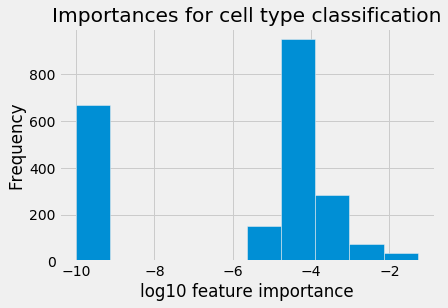

In [45]:
plt.hist(np.log10(feature_imp+1e-10))
plt.xlabel('log10 feature importance')
plt.ylabel('Frequency')
plt.title('Importances for cell type classification')
plt.show()

The manner in which we split our data into training and test sets will affect our model's performance. One factor that affects things is the fraction of data which is training or test. We can change this using the 'test_size' parameter in train_test_split. Let's build a for loop to see how this quantity affects our accuracy rate.

In [61]:
# Let's re-train with a different class imbalance. How do the confusion matrices compare?
test_acc = []
for i in [.9, .8, .7, .6, .5, .4, .3, .2, .1]:
    X_train, X_test, y_train, y_test = train_test_split(sc_features, sc_labels, test_size=1-i)
    clf=RandomForestClassifier(n_estimators = 200)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    test_acc.append(np.mean(y_test_pred == y_test))

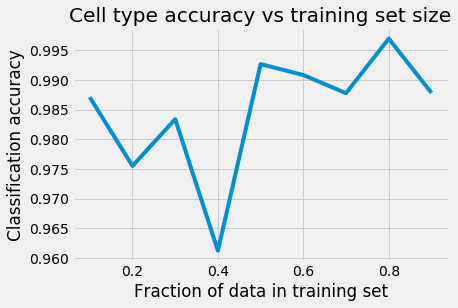

In [62]:
plt.plot([.9, .8, .7, .6, .5, .4, .3, .2, .1], test_acc)
plt.xlabel('Fraction of data in training set')
plt.ylabel('Classification accuracy')
plt.title('Cell type accuracy vs training set size')
plt.show()

# Comment on your resulting plot. What do you think is generally true about the relationship between how much data is in the training set and performance? You may want to run it a few times since there is some randomness in the process.

# Answer: Generally the performance of the classifer increases as the size of the training set grows. We should note that there's more variance in estimating the performance as the test set size shrinks.

Feature selection (and model selection) is another crucial component of classification tasks. Essentially, if we have many features, it may not be optimal to use all of them to build the model and we need some way to figure out what to keep and what to discard. One thing we can do is look at the accuracy on the test set as a function of the features we choose to keep. Let's see how our model performs when we truncate at different values of the feature importance.

In [53]:
# Let's re-train with fewer features (genes). How do the errors compare?
X_train, X_test, y_train, y_test = train_test_split(sc_features, sc_labels, test_size=.5)
clf=RandomForestClassifier(n_estimators = 200)

test_acc = []
for i in [0, .000001, .00001, .0001, .001, .01]:
    X_train_sub = X_train.T[feature_imp >= i].T
    X_test_sub = X_test.T[feature_imp >= i].T

    clf.fit(X_train_sub, y_train)
    # Compute train and test errors
    y_test_pred = clf.predict(X_test_sub)
    test_acc.append(np.mean(y_test_pred == y_test))

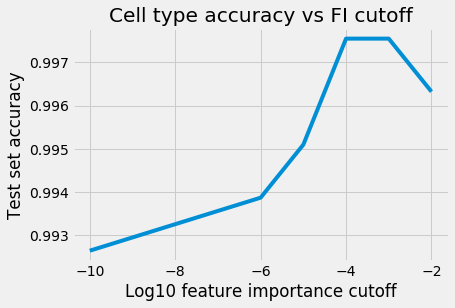

In [55]:
plt.plot(np.log10([0+1e-10, .000001, .00001, .0001, .001, .01]), test_acc)
plt.xlabel('Log10 feature importance cutoff')
plt.ylabel('Test set accuracy')
plt.title('Cell type accuracy vs FI cutoff')
plt.show()

# Comment on your resulting plot. For this data, what seems to be true about performance as a function of the number of features we retain? You may want to run it a few times since there is some randomness in the process.

# Answer: Initially, as we restrict to fewer features, the model performance improves. Eventually it seems this effect levels off, but the takeaway is that there's an optimal number of features (genes) to retain because of how informative they are. This is relevant to random forests because they randomly select features, so having many that are noisy can decrease our accuracy.

# Comment on how classification performed compared to clustering using t-SNE. Which was better? What is the key difference that makes one approach preferable to the other?

# Answer: Classification using RFs was notably better than the t-SNE and k-means approach. The key distinction was that classification required cell type labels, and learning the relationship between these labels and gene expression allows us to better classify new cells. t-SNE + k-means instead could only consider the distances in the projection space and didn't have access to the true labels at any point.